# **Week 2**
### Word Embeddings

<br>

---
***Embedding***  
The vectors for each word, with their associated sentiment.

- Each word is represented as a vector in a multi-dimensional space, not just a string of numbers representing words.
- Associated words are more clustered with each other in space per each iteration.



<br>

---
***The Results Of Embedding***  
2D array with the length of the sentence *(ex. 120)*, with the embedding dimension *(ex. 16)* as its size.

- Needs to be **Flatten**ed as in the image case, before being fed it to the dense neural network for the classification.

Layer Type | Output Shape | Param #
---------- | ------------ | -------
Embedding | (None, 120, 16) | 160,000
Flatten | (None, 1920) | 0
Dense | (None, 6) | 11,526
Dense | (None, 1) | 7

- Can also be **GlobalAveravePooling1D**ed instead of being **Flatten**ed, where vectors are averaged across.
  - Generally *faster but less accurate* than flattening.

Layer Type | Output Shape | Param #
---------- | ------------ | -------
Embedding | (None, 120, 16) | 160,000
GlobalAveravePooling1D | (None, 16) | 0
Dense | (None, 6) | 102
Dense | (None, 1) | 7



<br>

---
***Subwords***  
Sequence of the words are also important, not just the meaning of each word.
   


<br>

---
***Resources***

Datasets https://github.com/tensorflow/datasets/tree/master/docs/catalog

IMDB Large Movie Review Dataset http://ai.stanford.edu/~amaas/data/sentiment/

<br>

TensorFlow Subword Text Encoder https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/SubwordTextEncoder
- Seems to be depreciated

<br>

TensorFlow Projector https://projector.tensorflow.org/

<br><br>

---
## **Lab 1**
#### IMDB Dataset

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import io

print(tf.__version__)
!python --version

imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

# Datasets are pre-installed in colab
# !pip install -q tensorflow-datasets

2.6.0
Python 3.7.12


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9EBT52/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9EBT52/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete9EBT52/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


---
**Dataset Preparization**

In [2]:
# 25,000 for training, 25,000 for testing, each iterable
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Iterate over training and test datasets and extract sentences & labels
# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())
  
# Labels are expeccted to be NumPy arrays, so convert
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [3]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

# Expect more OOV words in test dataset: word_index derive from training dataset
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [4]:
# Helper function to reverse word index
# Key=Word & Value=Token to Key=Token & Value=Word
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[3]))
print(training_sentences[3])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? this is the kind of film for a snowy sunday afternoon when the rest of the world can go ahead with its own business as you <OOV> into a big arm chair and <OOV> for a couple of hours wonderful performances from cher and nicolas cage as always gently row the plot along there are no <OOV> to cross no dangerous waters just a warm and witty <OOV> through new york life at its best a family film in every sense and one that deserves the praise it received
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.


---
**Model constructed with _Flatten_**

In [5]:
model = tf.keras.Sequential([
    # The results of the embedding will be a 2D array with the length of the sentence, with the embedding dimension as its size.
    # Needs to be flattened
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 11526     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [6]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 6s 6ms/step - loss: 0.4963 - accuracy: 0.7416 - val_loss: 0.3446 - val_accuracy: 0.8501
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.2462 - accuracy: 0.9033 - val_loss: 0.3564 - val_accuracy: 0.8436
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.1050 - accuracy: 0.9693 - val_loss: 0.4314 - val_accuracy: 0.8327
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0263 - accuracy: 0.9963 - val_loss: 0.5252 - val_accuracy: 0.8241
Epoch 5/10
782/782 [==============================] - 5s 6ms/step - loss: 0.0065 - accuracy: 0.9994 - val_loss: 0.5956 - val_accuracy: 0.8253
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.6312 - val_accuracy: 0.8307
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 9.1135e-04 - accuracy: 1.0000 - val_loss: 0.6760 - val_accuracy: 0.8309
Ep

In [7]:
# Visualizing
# Result of the embeddings layer is at [0]
e = model.layers[0]
weights = e.get_weights()[0]

print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [8]:
# Initiate the files
out_v = io.open('vecs1.tsv', 'w', encoding='utf-8')
out_m = io.open('meta1.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]

  # Write the word
  out_m.write(word + "\n")

  # Write value of each of the items in embeddings
  # = Coefficient of each 16 dimension of the vector for the word
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

# Download the result
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs1.tsv')
  files.download('meta1.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
**Model constructed with _GlobalAveragePooling1D_**

In [9]:
model = tf.keras.Sequential([
    # The results of the embedding will be a 2D array with the length of the sentence, with the embedding dimension as its size.
    # Needs to be flattened
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 10
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 0.5569 - accuracy: 0.7499 - val_loss: 0.3829 - val_accuracy: 0.8411
Epoch 2/10
782/782 [==============================] - 4s 6ms/step - loss: 0.3336 - accuracy: 0.8610 - val_loss: 0.3315 - val_accuracy: 0.8579
Epoch 3/10
782/782 [==============================] - 4s 6ms/step - loss: 0.2720 - accuracy: 0.8895 - val_loss: 0.3272 - val_accuracy: 0.8584
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.2360 - accuracy: 0.9082 - val_loss: 0.3418 - val_accuracy: 0.8538
Epoch 5/10
782/782 [==============================] - 4s 6ms/step - loss: 0.2093 - accuracy: 0.9208 - val_loss: 0.3617 - val_accuracy: 0.8499
Epoch 6/10
782/782 [==============================] - 4s 6ms/step - loss: 0.1880 - accuracy: 0.9306 - val_loss: 0.4028 - val_accuracy: 0.8406
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.1703 - accuracy: 0.9387 - val_loss: 0.4240 - val_accuracy: 0.8392
Epoch 

---
**Result visualization: TensorFlow Projector**

In [11]:
# Result of the embeddings layer is at [0]
e = model.layers[0]
weights = e.get_weights()[0]

print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [12]:
# Initiate the files
out_v = io.open('vecs2.tsv', 'w', encoding='utf-8')
out_m = io.open('meta2.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]

  # Write the word
  out_m.write(word + "\n")

  # Write value of each of the items in embeddings
  # = Coefficient of each 16 dimension of the vector for the word
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

# Download the result
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs2.tsv')
  files.download('meta2.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
**Simple test with random sentence**

In [13]:
sentence = "I really think this is amazing. honest."
sequence = tokenizer.texts_to_sequences([sentence])
print(sequence)

[[11, 64, 102, 12, 7, 478, 1200]]


<br><br>

---
## **Lab 2**
#### Sarcasm Dataset

In [14]:
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import io

# Download sarcasm.json
!gdown --id 1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v

Downloading...
From: https://drive.google.com/uc?id=1xRU3xY5-tkiPGvlz5xBJ18_pHWSRzI4v
To: /content/sarcasm.json
100% 5.64M/5.64M [00:00<00:00, 87.5MB/s]


---
**Dataset Preparization**

In [15]:
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [16]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

# Split training and test dataset
# Dataset has about 27,000 items: 7,000 for testing
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [17]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

---
**Model construction and training**

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [19]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 3s - loss: 0.6565 - accuracy: 0.5975 - val_loss: 0.5442 - val_accuracy: 0.7310
Epoch 2/30
625/625 - 2s - loss: 0.4049 - accuracy: 0.8383 - val_loss: 0.3766 - val_accuracy: 0.8401
Epoch 3/30
625/625 - 2s - loss: 0.2956 - accuracy: 0.8832 - val_loss: 0.3567 - val_accuracy: 0.8435
Epoch 4/30
625/625 - 2s - loss: 0.2460 - accuracy: 0.9021 - val_loss: 0.3433 - val_accuracy: 0.8544
Epoch 5/30
625/625 - 2s - loss: 0.2100 - accuracy: 0.9191 - val_loss: 0.3505 - val_accuracy: 0.8520
Epoch 6/30
625/625 - 2s - loss: 0.1837 - accuracy: 0.9317 - val_loss: 0.3693 - val_accuracy: 0.8508
Epoch 7/30
625/625 - 2s - loss: 0.1607 - accuracy: 0.9396 - val_loss: 0.3944 - val_accuracy: 0.8442
Epoch 8/30
625/625 - 2s - loss: 0.1442 - accuracy: 0.9481 - val_loss: 0.3994 - val_accuracy: 0.8493
Epoch 9/30
625/625 - 2s - loss: 0.1280 - accuracy: 0.9546 - val_loss: 0.4200 - val_accuracy: 0.8505
Epoch 10/30
625/625 - 2s - loss: 0.1174 - accuracy: 0.9590 - val_loss: 0.4523 - val_accuracy: 0.8436

---
**Result visualization: Plot Graphs**

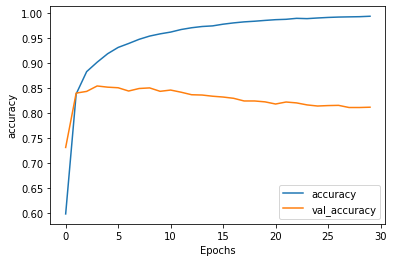

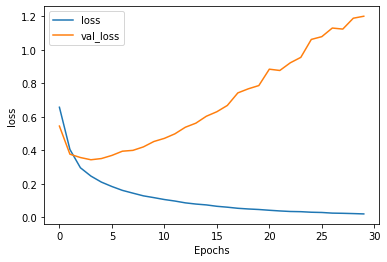

In [20]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

---
**Why does validation loss increase?**

- Occasionally happens with text data.

- Has to be experimented with different hyperparameters.

  1. Reducing vocab_size to 1,000, and max_length to 16.  
    - Loss flattens, but accuracy is not as high.

  2. Increasing embedding_dim to 32. Reducing vocab_size to 1,000, and max_length to 16.  
    - Little difference from 1.

---
**Result visualization: TensorFlow Projector**

In [21]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [22]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [23]:
out_v = io.open('vecs3.tsv', 'w', encoding='utf-8')
out_m = io.open('meta3.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs3.tsv')
  files.download('meta3.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---
**Simple test with random sentence**

In [24]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[9.5039928e-01]
 [1.4179889e-07]]


<br><br>

---
## **Lab 3**
#### IMDB Dataset: Subwords

In [25]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import io

print(tf.__version__)
!python --version

imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

# Datasets are pre-installed in colab
# !pip install -q tensorflow-datasets

2.6.0
Python 3.7.12


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete8UCSC1/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete8UCSC1/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete8UCSC1/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


---
**Dataset Preparazation**

Note that this is *case sensitive* and *punctuation is maintained*.

In [26]:
# Load train and test data
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_data, test_data = imdb['train'], imdb['test']

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))
test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

# Access subword tokenizer
tokenizer = info.features['text'].encoder
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [27]:
sample_string = 'TensorFlow, from basics to mastery'

# See how encoding is done
tokenized_string = tokenizer.encode(sample_string)
print ('Tokenized string is {}\n'.format(tokenized_string))

# See how decoding is done
original_string = tokenizer.decode(tokenized_string)
print ('The original string: {}\n'.format(original_string))

# See tokens themselves
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]

The original string: TensorFlow, from basics to mastery

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


---
**Model construction and training**

In [28]:
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),       # FLATTENING THIS MIGHT CAUSE TF TO CRASH!!!
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [29]:
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)

Epoch 1/10
391/391 [==============================] - 18s 42ms/step - loss: 0.6811 - accuracy: 0.5746 - val_loss: 0.6531 - val_accuracy: 0.7270
Epoch 2/10
391/391 [==============================] - 17s 41ms/step - loss: 0.5477 - accuracy: 0.7856 - val_loss: 0.4495 - val_accuracy: 0.8350
Epoch 3/10
391/391 [==============================] - 17s 42ms/step - loss: 0.3650 - accuracy: 0.8753 - val_loss: 0.3574 - val_accuracy: 0.8602
Epoch 4/10
391/391 [==============================] - 17s 41ms/step - loss: 0.2896 - accuracy: 0.8988 - val_loss: 0.3231 - val_accuracy: 0.8753
Epoch 5/10
391/391 [==============================] - 17s 41ms/step - loss: 0.2529 - accuracy: 0.9109 - val_loss: 0.3100 - val_accuracy: 0.8794
Epoch 6/10
391/391 [==============================] - 17s 42ms/step - loss: 0.2270 - accuracy: 0.9206 - val_loss: 0.3053 - val_accuracy: 0.8801
Epoch 7/10
391/391 [==============================] - 17s 41ms/step - loss: 0.2097 - accuracy: 0.9257 - val_loss: 0.3039 - val_accuracy:

---
**Result visualization**

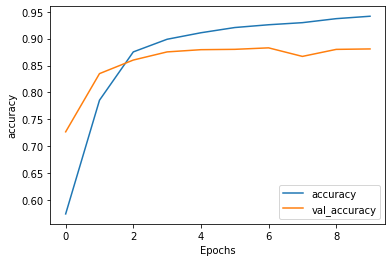

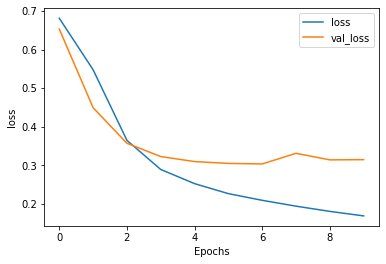

In [30]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

---
**Why is the accuracy only about 50%, and the loss increases?**

- Subword meanings are often non sensical. Only when we put them together in sequences, they have meaningful semantics.

  - Learning from sequences requires *recurrent neural networks*.

---
**Result visualization: TensorFlow Projector**

In [31]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(8185, 64)


In [32]:
out_v = io.open('vecs4.tsv', 'w', encoding='utf-8')
out_m = io.open('meta4.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs4.tsv')
  files.download('meta4.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>